# Predictive Modeling of Ames House Prices

## Problem Statement:  

Iowa Appraisals is experiencing a loss of client and a dwindling market share in Ames, Iowa, due to its unreliable property appraisals. Here, we build a predictive model for property appraisal in the target city, Ames, Iowa, to allow Iowa Appraisals to provide meaningful estimates to prospective property sellers and buyers in the area and regain client satisfaction and market share from its competitors.

Client:   Iowa Appraisals & Research Inc.

## Table of Content
- [Background](#Background)
- [Part 1: Data Cleaning](#Data_Cleaning)
- [Part 2: Exploratory Data Analysis](#Exploratory_Data_Analysis)
- [Part 3: Predictive Modeling](#Predictive_Modeling)
- [Part 4: Predictive Model Target Application](#Target_Model)
- [Part 5: Conclusion and Recommendations](#Conclusion)







## Background: <a class="anchor" id="Background"></a>

Real estate appraisals are a key component of the whole process of buying or selling a property. Prior to the usage of data to find home appraisals, owners look around the area to measure the average house price and measure only a few variables such as square footage or number of rooms. Today, appraisal agents compete against one another to provide the greatest value to their clients ([*source*](https://www.forbes.com/sites/taramastroeni/2018/07/31/what-is-an-appraisal-and-why-you-need-one-on-your-new-home/?sh=182f0643d878)). One of the key metrics of client satisfaction is the based on attaining the fair market value of their homes. To fulfill the client's needs, the usage of data science is vital. Conducted incorrectly, this leads to unsatisfied clients, lowering the competitiveness against other appraisal firms. At the same time, agents who provide appropriate property values become a reliable source of appraisals.

# Part 1: Data Cleaning <a class="anchor" id="Data_Cleaning"></a>

## 1.1. Imports:

Below are the modules and functions imported from its respective libraries to be used in this task.

In [1]:
# All imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import patsy

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.linear_model import (
    LinearRegression, 
    RidgeCV, 
    LassoCV, 
    ElasticNetCV, 
    Ridge, 
    Lasso, 
    ElasticNet
)

import statsmodels.api as sm

## 1.2. Read Data & Rename Columns

Renaming columns by replacing space with underscore to comply with common practice.

In [2]:
# Reading dataset
housing_old = pd.read_csv('datasets/train.csv')
housing_old.columns = housing_old.columns.str.replace(' ', '_')
housing = housing_old

## 1.3. Initial Data Viewing

#### Observations:
1. Training data has 2051 rows and 81 columns. 

2. Type of data: objects, integers and floats

3. Many columns with missing data.

In [3]:
print(housing.shape, '\n')
print(housing.dtypes, '\n')
print([col for col in housing.columns if housing[col].isnull().any()])

(2051, 81) 

Id                int64
PID               int64
MS_SubClass       int64
MS_Zoning        object
Lot_Frontage    float64
                 ...   
Misc_Val          int64
Mo_Sold           int64
Yr_Sold           int64
Sale_Type        object
SalePrice         int64
Length: 81, dtype: object 

['Lot_Frontage', 'Alley', 'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt', 'Garage_Finish', 'Garage_Cars', 'Garage_Area', 'Garage_Qual', 'Garage_Cond', 'Pool_QC', 'Fence', 'Misc_Feature']


## 1.4. Imputations

Here, we conduct several imputations based on general knowledge and inference.

### 1.4.1. Deductive Imputations

Several quantitative and qualitative variables have instances of 'Nan', which is both not useful for our model and will produce errors. In some of these variables, 'Nan' can be reasoanably be deduced as the absence of the variable measured. In such cases, we will replace 'NaN' with 0. The variables where we conduct deductive imputations are as follows:

    1. Masonry Veneer Area
    2. Masonry Veneer Type
    3. Basement 1 Square Footage
    4. Total Basement Square Footage
    5. Basement Full Baths
    6. Basement Unfinishes Square Footage
    7. Basement Half Baths
    8. Garage Year Built
    9. Garage Type
    10. Basement 2 Square Footage
    11. Garage Car Capacity
    12. Garage Square Footage

In [4]:
nan_to_zero_list = ['Mas_Vnr_Area', 'Mas_Vnr_Type', 'BsmtFin_SF_1', 'Total_Bsmt_SF',
                    'Bsmt_Full_Bath', 'Bsmt_Unf_SF', 'Bsmt_Half_Bath', 'Garage_Yr_Blt',
                    'Garage_Type', 'BsmtFin_SF_2', 'Garage_Cars', 'Garage_Area'
                   ]

for column in nan_to_zero_list:
    housing[column] = housing[column].fillna(0)

### 1.4.2. Linear Regression Imputation (1 Column Added)

We find 321 missing values under Lot Frontage. Our initial thought is that this variable may have a factor of importance. As such, we believe that we should try to conduct some imputations. We believe that Lot Frontage may be reasonably deduced by linear regressions using these variables:

    1. Lot Area
    2. Year Built
    3. Sale Price
    4. Total Rooms
    
Since this is a linear regression, we would like to note several things:

    1. We do not use Sale Price as a variable to impute this value since Sale Price is our target. Doing so would cause problems in a test set where we are trying to find the Sale Price.   
    
    2. Plotting an imputed variable against the target (Sale Price) may result in a greater variance since the target variable was used to impute this variable. As such, in plotting Lot Frontage against Sale Price during Exploratory Data Analysis, the raw Lot Frontage with null values should be used instead.
    
<blockquote><b>
        
    Old Shape: 2051 Rows, 81 Columns
    New Shape: 2051 Rows, 82 Columns

</b></blockquote>

In [5]:
housing_impute = housing_old.dropna(subset=['Lot_Frontage'])

X_impute = housing_impute[['TotRms_AbvGrd', 'Lot_Area', 'Year_Built']]
y_impute = housing_impute['Lot_Frontage']

lr = LinearRegression()

lr.fit(X_impute, y_impute)

missing_idx = housing.index[housing_old['Lot_Frontage'].isnull()]

housing['Lot_Frontage_Imputed'] = [housing.loc[index,'Lot_Frontage'] if index not in missing_idx
     else lr.predict(pd.DataFrame(housing.loc[index,['TotRms_AbvGrd', 'Lot_Area', 'Year_Built']]).T)[0]
     for index in range(housing.shape[0])]

### 1.5. Changing Ordinal Values from String to Integer

A few columns were changed from its string ordinal form into an integer ordinal form. These data are unlikely to be useful in it's current string form (Excellent, Good, etc). Therefore, we replaced its current string values into an ordinal form based on highest to lowest desirability, were more desirable features are given a higher value while less desirable features are given lower value. 


**1.5.1. 3-Value Ordinals (4 Columns Modified)**

Several 3-value ordinal columns were changed into integer format:

    1. Utilities
    2. Land Slope
    3. Paved Drive
    4. Garage Finish


    
|Old Column Data|New Column Data|<center>Description (Utilities)</center>|
|---------------|---------------|-----------|
|<center>AllPub</center>|<center>3</center>|<center>All public Utilities (Electricity, Gas, Water & Sewage)</center>|
|<center>NoSewr</center>|<center>2</center>|<center>Electricity, Gas, Water (Septic Tank) Only</center>|
|<center>NoSeWa</center>|<center>1</center>|<center>Electricity and Gas Only</center>|

    
|Old Column Data|New Column Data|<center>Description (Land Slope)</center>|
|---------------|---------------|-----------|
|<center>Gtl</center>|<center>3</center>|<center>All public Utilities (Electricity, Gas, Water & Sewage)</center>|
|<center>Mod</center>|<center>2</center>|<center>Electricity, Gas, Water (Septic Tank) Only</center>|
|<center>Sev</center>|<center>1</center>|<center>Electricity and Gas Only</center>|

|Old Column Data|New Column Data|<center>Description (Paved Drive)</center>|
|---------------|---------------|-----------|
|<center>Y</center>|<center>3</center>|<center>Paved</center>|
|<center>P</center>|<center>2</center>|<center>Partial Pavement</center>|
|<center>N</center>|<center>1</center>|<center>Dirt/Gravel</center>|

|Old Column Data|New Column Data|Description (Garage Finish)|
|---------------|---------------|-----------|
|<center>Fin</center>|<center>3</center>|<center>Finished</center>|
|<center>RFn</center>|<center>2</center>|<center>Roughly Finished</center>|
|<center>Unf</center>|<center>1</center>|<center>Unfinished</center>|
|<center>nan</center>|<center>0</center>|<center>No Garage</center>|
    


In [6]:
housing['Utilities'] = housing['Utilities'].map({'AllPub': 3, 
                                                 'NoSeWa': 2, 
                                                 'NoSewr': 1})

housing['Land_Slope'] = housing['Land_Slope'].map({'Gtl': 3,
                                                   'Mod': 2,
                                                   'Sev': 1})

housing['Paved_Drive'] = housing['Paved_Drive'].map({'Y': 3,
                                                     'P': 2,
                                                     'N': 1})

housing['Garage_Finish'] = housing['Garage_Finish'].fillna('NA').map({'Fin': 3,
                                                                      'RFn': 2,
                                                                      'Unf': 1,
                                                                      'NA': 0})

**1.5.2. 4-Value Ordinals (6 Columns Modified)**

Similar to above, several 4-value ordinals are changed from its string form into integers. The columns modified are:

    1. Lot Shape
    2. Exterior Quality
    3. Kitchen Quality
    4. Fence
    5. Pool Quality
    6. Basement Exposure
    
|Old Column Data|New Column Data|<center>Description (Lot Shape)</center>|
|---------------|---------------|-----------|
|<center>Reg</center>|<center>4</center>|<center>Regular</center>|
|<center>IR1</center>|<center>3</center>|<center>Slightly Irregular</center>|
|<center>IR2</center>|<center>2</center>|<center>Moderately Irregular</center>|
|<center>IR3</center>|<center>1</center>|<center>Irregular</center>|

|Old Column Data|New Column Data|Description (Exterior Quality, Kitchen Quality)|
|---------------|---------------|-----------|
|<center>Ex</center>|<center>4</center>|<center>Excellent</center>|
|<center>Gd</center>|<center>3</center>|<center>Good</center>|
|<center>TA</center>|<center>2</center>|<center>Average/Typical</center>|
|<center>Fa</center>|<center>1</center>|<center>Fair</center>|
    
|Old Column Data|New Column Data|Description (Fence)|
|---------------|---------------|-----------|
|<center>GdPrv</center>|<center>4</center>|<center>Good Privacy</center>|
|<center>MnPrv</center>|<center>3</center>|<center>Minimum Privacy</center>|
|<center>GdWo</center>|<center>2</center>|<center>Good Wood</center>|
|<center>MnWw</center>|<center>1</center>|<center>Minimum Wood/Wire</center>|
|<center>nan</center>|<center>0</center>|<center>No Fence</center>|
    
|Old Column Data|New Column Data|Description (Pool Quality)|
|---------------|---------------|-----------|
|<center>Ex</center>|<center>4</center>|<center>Excellent</center>|
|<center>Gd</center>|<center>3</center>|<center>Good</center>|
|<center>TA</center>|<center>2</center>|<center>Average/Typical</center>|
|<center>Fa</center>|<center>1</center>|<center>Fair</center>|
|<center>nan</center>|<center>0</center>|<center>No Pool</center>|
    
|Old Column Data|New Column Data|Description (Basement Exposure)|
|---------------|---------------|-----------|
|<center>Gd</center>|<center>4</center>|<center>Good Exposure</center>|
|<center>Av</center>|<center>3</center>|<center>Average Exposure</center>|
|<center>Mn</center>|<center>2</center>|<center>Minimal Exposure</center>|
|<center>No</center>|<center>1</center>|<center>No Exposure</center>|
|<center>nan</center>|<center>0</center>|<center>No Pool</center>|


In [7]:
housing['Lot_Shape'] = housing['Lot_Shape'].map({'Reg': 4,
                                                 'IR1': 3,
                                                 'IR2': 2,
                                                 'IR3': 1})

housing['Pool_QC'] = housing['Pool_QC'].fillna('NA').map({'Ex': 4,
                                                          'Gd': 3,
                                                          'Fa': 2,
                                                          'TA': 1,
                                                          'NA': 0})

housing['Fence'] = housing['Fence'].fillna('NA').map({'GdPrv': 4,
                                                      'MnPrv': 3,
                                                      'GdWo': 2,
                                                      'MnWw': 1,
                                                      'NA': 0})

housing['Bsmt_Exposure'] = housing['Bsmt_Exposure'].fillna('NA').map({'Gd': 4,
                                                                      'Av': 3,
                                                                      'Mn': 2,
                                                                      'No': 1,
                                                                      'NA': 0})

ordinal_4_list_1 = ['Exter_Qual', 'Kitchen_Qual']

ordinal_4_scale_1 = {'Ex': 4,
                     'Gd': 3,
                     'TA': 2,
                     'Fa': 1
                    }

for column in ordinal_4_list_1:
    housing[column] = housing[column].map(ordinal_4_scale_1)
    

**1.5.3. 5-Value Ordinals (8 Columns Modified)**

Similar to above, several 5-value ordinals are changed from its string form into integers. The columns modified are:

    1. Exterior Condition
    2. Heating Quality
    3. Electrical
    4. Fireplace Quality
    5. Basement Quality
    6. Basement Condition
    7. Garage Quality
    8. Garage Condition
    
    
|Old Column Data|New Column Data|Description (Exterior Condition, Heating Quality)|
|---------------|---------------|-----------|
|<center>Ex</center>|<center>5</center>|<center>Excellent</center>|
|<center>Gd</center>|<center>4</center>|<center>Good</center>|
|<center>TA</center>|<center>3</center>|<center>Average/Typical</center>|
|<center>Fa</center>|<center>2</center>|<center>Fair</center>|
|<center>Po</center>|<center>1</center>|<center>Poor</center>|


|Old Column Data|New Column Data|<center>Description (Electrical)</center>|
|---------------|---------------|-----------|
|<center>SBrkr</center>|<center>5</center>|<center>Standard Circuit Breakers & Romex</center>|
|<center>FuseA</center>|<center>4</center>|<center>Fuse Box Over 60 AMP and All Romex Wiring (Average)</center>|
|<center>FuseF</center>|<center>3</center>|<center>0 AMP Fuse Box and Mostly Romex Wiring (Fair)</center>|
|<center>FuseP</center>|<center>2</center>|<center>60 AMP Fuse Box and Mostly Knob & Tube Wiring (Poor)</center>|
|<center>Mix</center>|<center>1</center>|<center>Mix (Undesirable)</center>|


|<center>Old Column Data</center>|<center>New Column Data</center>|<center>Desc (Fireplace Quality)</center>|<center>Desc (Basement Quality)</center>|<center>Desc (Basement Condition, Garage Quality, Garage Condition)</center>|
|---------------|---------------|-----------|-|-|
|<center>Ex</center>|<center>5</center>|<center>Exceptional Masonry Fireplace</center>|<center>Excellent (100+ inches)</center>|<center>Excellent</center>|
|<center>Gd</center>|<center>4</center>|<center>Masonry Fireplace</center>|<center>Good (90-99 inches)</center>|<center>Good</center>|
|<center>TA</center>|<center>3</center>|<center>Prefabricated Fireplace in main living area or Masonry Fireplace in basement</center>|<center>Average/Typical (80-89 inches)</center>|<center>Average/Typical</center>|
|<center>Fa</center>|<center>2</center>|<center>Prefabricated Fireplace in basement</center>|<center>Fair (70-79 inches)</center>|<center>Fair</center>|
|<center>Po</center>|<center>1</center>|<center>Ben Franklin Stove</center>|<center>Poor (< 70 inches)</center>|<center>Poor</center>|
|<center>nan</center>|<center>0</center>|<center>No Fireplace</center>|<center>No Basement</center>|<center>No Basement</center>|

In [8]:
housing['Electrical'] = housing['Electrical'].map({'SBrkr': 5,
                                                   'FuseA': 4,
                                                   'FuseF': 3,
                                                   'FuseP': 2,
                                                   'Mix': 1})
    
    
ordinal_5_list_1 = ['Exter_Cond', 'Heating_QC']

ordinal_5_scale_1 = {'Ex': 5,
                     'Gd': 4,
                     'Fa': 3,
                     'TA': 2,
                     'Po': 1,}

for column in ordinal_5_list_1:
    housing[column] = housing[column].map(ordinal_5_scale_1)

    
ordinal_5_list_2 = ['Fireplace_Qu', 'Bsmt_Qual', 'Bsmt_Cond', 'Garage_Qual', 'Garage_Cond']

ordinal_5_scale_2 = {'Ex': 5,
                     'Gd': 4,
                     'Fa': 3,
                     'TA': 2,
                     'Po': 1,
                     'NA': 0}

for column in ordinal_5_list_2:
    housing[column] = housing[column].fillna('NA').map(ordinal_5_scale_2)

**1.5.4. 6-Value Ordinals (2 Columns Modified)**

Similar to above, several 6-value ordinals are changed from its string form into integers. The columns modified are:

    1. Rating of Basement 1 Finished Area
    2. Rating of Basement 2 Finished Area
    
|Old Column Data|New Column Data|Description (Basement Type 1, Basement Type 2)|
|---------------|---------------|-----------|
|<center>GLQ</center>|<center>6</center>|<center>Good Living Quarters</center>|
|<center>ALQ</center>|<center>5</center>|<center>Average Living Quarters</center>|
|<center>BLQ</center>|<center>4</center>|<center>Below Average Living Quarters</center>|
|<center>Rec</center>|<center>3</center>|<center>Average Rec Room</center>|
|<center>LwQ</center>|<center>2</center>|<center>Low Quality</center>|
|<center>Unf</center>|<center>1</center>|<center>Unfinshed</center>|
|<center>NA</center>|<center>0</center>|<center>No Basement</center>|

In [9]:
ordinal_6_list = ['BsmtFin_Type_1', 'BsmtFin_Type_2']

ordinal_6_scale = {'GLQ': 6,
                   'ALQ': 5,
                   'BLQ': 4,
                   'Rec': 3,
                   'LwQ': 2,
                   'Unf': 1,
                   'NA': 0}

for column in ordinal_6_list:
    housing[column] = housing[column].fillna('NA').map(ordinal_6_scale)

**1.5.5. 8-Value Ordinals (1 Column Modified)**

Similar to above, several ordinals are changed from its string form into integers. The columns modified are:

    1. Home Functionality
    
|Old Column Data|New Column Data|Description (Home Functionality)|
|---------------|---------------|-----------|
|<center>Typ</center>|<center>8</center>|<center>Typical Functionality</center>|
|<center>Min1</center>|<center>7</center>|<center>Minor Deductions 1</center>|
|<center>Min2</center>|<center>6</center>|<center>Minor Deductions 2</center>|
|<center>Mod</center>|<center>5</center>|<center>Moderate Deductions</center>|
|<center>Maj1</center>|<center>4</center>|<center>Major Deductions 1</center>|
|<center>Maj2</center>|<center>3</center>|<center>Major Deductions 2</center>|
|<center>Sev</center>|<center>2</center>|<center>Severely Damaged</center>|
|<center>Sal</center>|<center>1</center>|<center>Salvage only</center>|


In [10]:
housing['Functional'] = housing['Functional'].map({'Typ': 8,
                                                   'Min1': 7,
                                                   'Min2': 6,
                                                   'Mod': 5,
                                                   'Maj1': 4,
                                                   'Maj2': 3,
                                                   'Sev': 2,
                                                   'Sal': 1})

### 1.6. Resolving Incompatible Data

Several datapoints were found to be incompatible due to the absence of its base features.

#### 1.6.1. Drop Incompatible Basement Data (1 Row Dropped)

We found 1 datapoint where a Basement 2 Area was found (greater than 0sqft) while Basement 2 Type was 'nan'. Through our previos permutations, we have converted it from 'nan' to '0'. However, since a Basement 2 Area was found, this datapoint's Basement 2 descriptions are incompatible. Since we cannot reasonably impute a value to the Basement 2 Type, we have decided that it would be better to drop this observation. A deletion of one datapoint should not materially affect the model. This results in the elimination of 1 datapoint.

<blockquote><b>
       
    Old Shape: 2051 Rows, 82 Columns
    New Shape: 2050 Rows, 82 Columns

</b></blockquote>

In [11]:
housing.drop(housing.loc[(housing['BsmtFin_Type_2'] == 0) & (housing['BsmtFin_SF_2'] != 0)].index, inplace=True)


#### 1.6.2. Further Deductive Imputation (603 Basement 1 Type, 1747 Basement 2 Type Modified)

Further deductive imputation was conducted to suit several variables into its main features. This could only be conducted after imputations from the previous step due to its initial string type, which has now been converted to numeric. For instance, we conducted a check to compare Basement Type and Basement Area. We found that there were many observations where Basement Area is absent (no basement), however, Basement Type was present. Since there are a large number of observations with this characteristics (600+ and 1700+ for Basement 1 and 2 respectively), we decided that these datapoints cannot be dropped. To resolve this issue, we imputed Basement Type as '0' where Basement Area is '0' to denote an absence of a basement for both type and square footage. This results in the modification of 603 and 1747 observations for Basement 1 and 2 respectively. 

Below is a list of variables where deductive imputation was conducted and the number of rows affected:

|<center>Column</center>|Number of Observations Modified|
|-----------------------|-------------------------------|    
|Basement Type 1|<center>603</center>|
|Basement Type 2|<center>1747</center>|
|Garage Type|<center>1</center>|

In [12]:
def deductive_impute(row):
    if row['BsmtFin_SF_1'] == 0:
        row['BsmtFin_Type_1'] = 0
    if row['BsmtFin_SF_2'] == 0:
        row['BsmtFin_Type_2'] = 0
    if row['Garage_Area'] == 0:
        row['Garage_Type'] = 0
    return row

housing = housing.apply(deductive_impute, axis=1)

### 1.7. Dummify Columns

#### 1.7.1. Dummify Alley: Gravel or Paved (1 Column Dropped, 2 Columns Added)

Most of our observations do not have an 'Alley', while those which do are divided between 'Gravel' and 'Paved'. As such, we applied a dummy variable where '1' on 'Alley_Gravel' or 'Alley_Paved' denotes whether the property has a gravel or paved alley, while '0' on both cases signify the absence of an alley.

<blockquote><b>
        
    Old Shape: 2050 Rows, 82 Columns
    New Shape: 2050 Rows, 83 Columns

</b></blockquote>

In [13]:
housing = pd.get_dummies(housing,
                    columns=['Alley'],
                   )

**1.7.2. Dummify Miscellaneous Features: Categorical to Binary (64 Rows Modified, 1 Column Replaced)**

Under Miscellaneous Features, there are 64 observations where this is true. Within those 64 observations, 56 of the miscellaneous features are sheds with over 100sqft, whereas the next largest group of observations have just 4 observations. Due to the small number of observations with unique features, we will instead replace this into a binary group, where '1' and '0' represents the presence and absence of a miscellaneous feature in the property respectively.

In [14]:
misc_feature_list = ['Shed', 'Gar2', 'Othr', 'TenC']
housing['Misc_Feature_Yes'] = [0 if feature not in misc_feature_list else 1 for feature in housing['Misc_Feature']]
housing.drop(columns=['Misc_Feature'], inplace=True)

## 1.8. Dropping Columns and Rows

In this section, we will be conducting data cleaning and dropping columns and rows wherever necessary. Justifications for dropping columns and rows are provided to enable a better understanding of why certain columns or rows are dropped. <b>Headers are formatted as such:</b>


    
    Name of Columns / Rows Dropped (Number of Rows or Columns Dropped)


### 1.8.1. ID, PID (2 Columns Dropped)

We drop ID and PID since they are simply an identifier of the property and its tax-related ID and does not have any relation to its main selling features. This results in the elimination of 2 columns.

<blockquote><b>
        
    Old Shape: 2050 Rows, 83 Columns
    New Shape: 2050 Rows, 81 Columns

</b></blockquote>

In [15]:
housing.drop(columns=['Id', 'PID'], inplace=True)

### 1.8.2. Drop Column: Sale Type (1 Column Dropped)

Generally, the type of sale is independent of the price of sale, as the sale type will only be done after the sale has been made. For this reason, we believe that sale type is not a suitable variable to estimate sale price and decideed to drop the column. This results to the elimination of 1 column.

<blockquote><b>
        
    Old Shape: 2050 Rows, 81 Columns
    New Shape: 2050 Rows, 80 Columns

</b></blockquote>

In [16]:
housing.drop(columns='Sale_Type', inplace=True)

### 1.8.3. Drop Rows: Garage_Yr_Blt  (2 Rows Dropped)

Two observations from viewing data using the .describe() function. The highest value in "Garage_Yr_Blt" will only occur in two centuries (Year 2207), which is most likely a wrong input and therefore should be dropped. Additionally, the year where the garage was built should not be higher than the year where the house was sold, since the data was not updated after the sale. Filtering for both of these result in the elimination of 2 rows.

<blockquote><b>
       
    Old Shape: 2050 Rows, 80 Columns
    New Shape: 2048 Rows, 80 Columns

</b></blockquote>

In [17]:
display(housing.loc[housing['Garage_Yr_Blt'] > housing['Yr_Sold'], ['Garage_Yr_Blt', 'Yr_Sold']])
housing.drop(housing.loc[housing['Garage_Yr_Blt'] > housing['Yr_Sold']].index, inplace=True)
housing.reset_index(inplace=True, drop=True)

,Garage_Yr_Blt,Yr_Sold
1699,2207.0,2007
1885,2008.0,2007


## 1.9. Data Dictionary

|Column|Type|Description|
|------|----|-----------|
Lot_Area|int64|Lot size (sqft)
MS_SubClass|object|Property Zoning Classification
Overall_Qual|int64|Overall Quality of Property
Exter_Qual|object|Property External Quality
Total_Bsmt_SF|float64|Total Basement Area (sqft)
Heating|object|Heating Type
Neighborhood|object|Property Neighborhood Name
Gr_Liv_Area|int64|Size of Living Area (sqft)
Garage_Area|float64|Size of Garage (sqft)
SalePrice|int64|Sale Price of Property
SP_LA|float|Sale Price per Lot Area ($/sqft)
House_Sold_Age|int64|Age of House at Sale (years)


# Part 2: Exploratory Data Analysis <a class="anchor" id="Exploratory_Data_Analysis"></a>



## 2.1. Zone/Neighborhood Classification

### 2.1.1. Boxplot of Sale Price Per Lot Area Based on Zone Classification

Below is a boxplot of sale price per lot area based on the property's zoning classification. We observe differences in the median price based on this metric, where non-residential classifications have a lower sale price per lot area as compared to its residential peers. In general, residential properties are valued higher by this metric due to its higher utility as a residential housing as compared business-related purposes. Knowing this, we ought to use this variable as a component of our model.

<blockquote><b>
        
    Old Shape: 2048 Rows, 80 Columns
    New Shape: 2048 Rows, 81 Columns

</b></blockquote>

In [18]:
housing['SP_LA'] = housing['SalePrice'] / housing['Lot_Area']

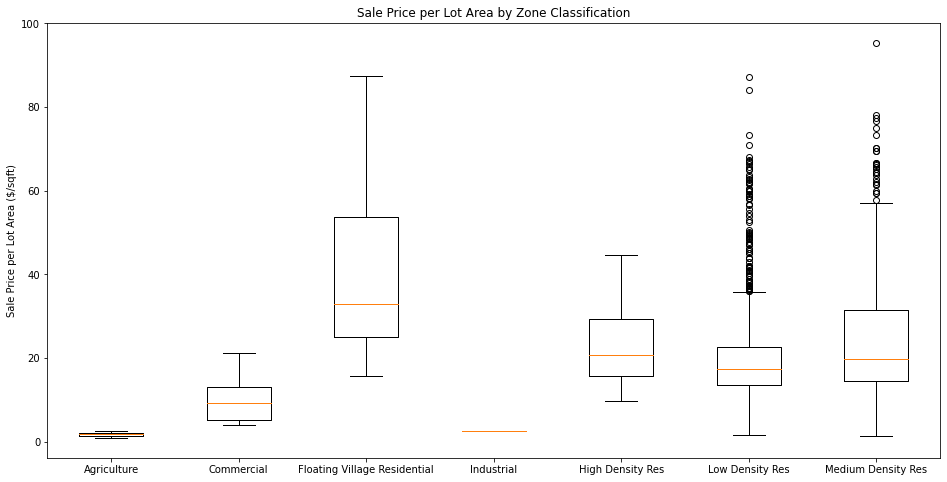

In [19]:
plt.figure(figsize=(16, 8))

plt.boxplot([housing.loc[housing['MS_Zoning'] == 'A (agr)', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'C (all)', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'FV', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'I (all)', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'RH', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'RL', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'RM', "SP_LA"]
            ]);
plt.title('Sale Price per Lot Area by Zone Classification')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7],
           labels=['Agriculture', 
                   'Commercial', 
                   'Floating Village Residential',
                   'Industrial',
                   'High Density Res',
                   'Low Density Res',
                   'Medium Density Res'
                  ]
);
plt.ylabel('Sale Price per Lot Area ($/sqft)');

### 2.1.2. Boxplot of Sale Price Per Lot Area Based on Neighborhood

Below, we plot the sale price of properties per lot area ($/sqft). We observe that the qualitative variable 'neighborhood' makes a notable impact in the price per square footage in the observations we have. This suggests that this variable plays a meaningful role in the valuation of properties in Ames. As such, we should incorporate this variable into our predictive model.

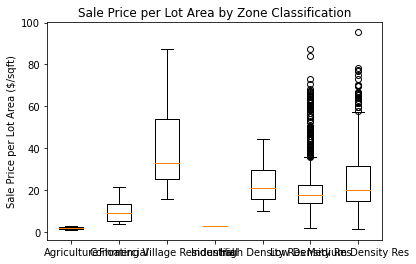

In [20]:
plt.boxplot([housing.loc[housing['MS_Zoning'] == 'A (agr)', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'C (all)', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'FV', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'I (all)', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'RH', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'RL', "SP_LA"],
             housing.loc[housing['MS_Zoning'] == 'RM', "SP_LA"]
            ]);


plt.title('Sale Price per Lot Area by Zone Classification')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7],
           labels=['Agriculture', 
                   'Commercial', 
                   'Floating Village Residential',
                   'Industrial',
                   'High Density Res',
                   'Low Density Res',
                   'Medium Density Res'
                  ]
);
plt.ylabel('Sale Price per Lot Area ($/sqft)');





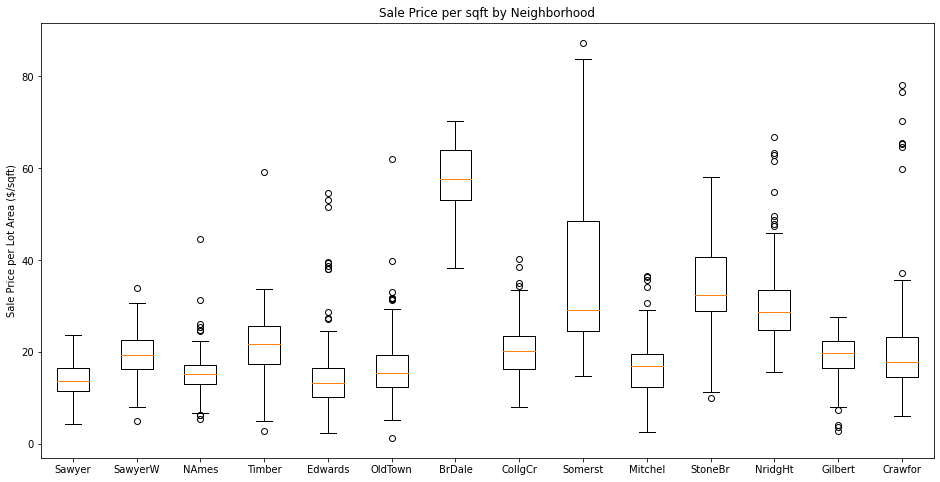

In [21]:
plt.figure(figsize=(16, 8))

neighborhood_list_1 = ['Sawyer', 'SawyerW', 'NAmes', 'Timber', 'Edwards', 'OldTown', 'BrDale', 
                       'CollgCr', 'Somerst', 'Mitchel', 'StoneBr', 'NridgHt', 'Gilbert', 'Crawfor']

plt.boxplot([housing.loc[housing['Neighborhood'] == 'Sawyer', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'SawyerW', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'NAmes', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Timber', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Edwards', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'OldTown', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'BrDale', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'CollgCr', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Somerst', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Mitchel', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'StoneBr', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'NridgHt', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Gilbert', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Crawfor', "SP_LA"],]);

plt.title('Sale Price per sqft by Neighborhood')
plt.xticks(ticks=[i for i in range(1, 15)],
           labels=[i for i in neighborhood_list_1
                  ]
);
plt.ylabel('Sale Price per Lot Area ($/sqft)');

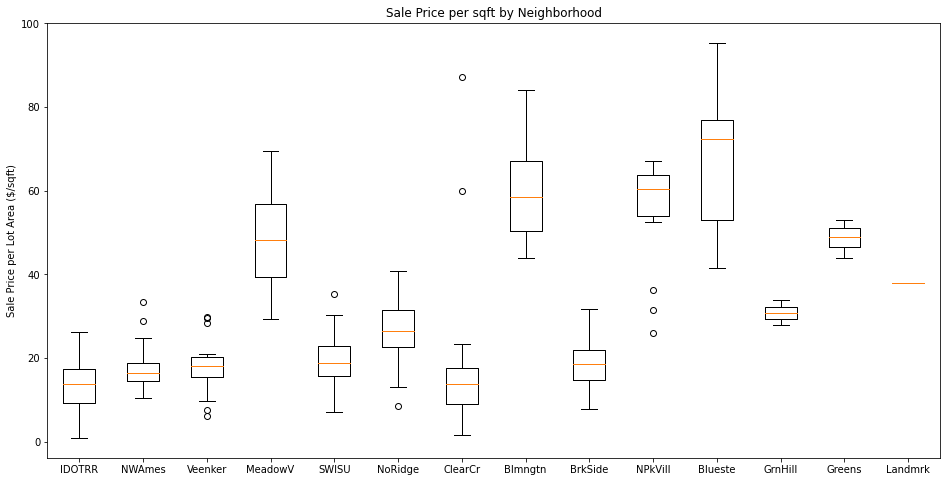

In [22]:
plt.figure(figsize=(16, 8))
plt.boxplot([housing.loc[housing['Neighborhood'] == 'IDOTRR', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'NWAmes', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Veenker', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'MeadowV', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'SWISU', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'NoRidge', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'ClearCr', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Blmngtn', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'BrkSide', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'NPkVill', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Blueste', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'GrnHill', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Greens', "SP_LA"],
             housing.loc[housing['Neighborhood'] == 'Landmrk', "SP_LA"],])

neighborhood_list_2 = ['IDOTRR', 'NWAmes', 'Veenker', 'MeadowV', 'SWISU', 'NoRidge', 'ClearCr', 
                       'Blmngtn', 'BrkSide', 'NPkVill', 'Blueste', 'GrnHill', 'Greens', 'Landmrk']

plt.title('Sale Price per sqft by Neighborhood')
plt.xticks(ticks=[i for i in range(1, 15)],
           labels=[i for i in neighborhood_list_2
                  ]
);
plt.ylabel('Sale Price per Lot Area ($/sqft)');

## 2.2. Sale Price Trend by Year and Month (1 Column Added)

The lineplot below shows the mean and interquartile range of sale price per lot area throughout the year and months in the data. From this, we observe a few things:

1. While we see a fluctuation in mean sale price per square footage throughout the years, they do not appear to be seasonal fluctuations. Since seasonality seems lacking, this suggests that directly using the variables year and month sold may not be useful in our model.

2. The Great Recession occurred during this time period. We can see the effect of this housing crisis as sale price per square footage decreased in 1st quarter 2008 as mean sale price per square footage dropped from about \\$25/sqft to about \\$19/sqft and a contraction in the range of sale price per square footage during this period. We also observe a recovery from the dip post 2008 througout the rest of the year.

<blockquote><b>
        
    Old Shape: 2048 Rows, 81 Columns
    New Shape: 2048 Rows, 82 Columns

</b></blockquote>

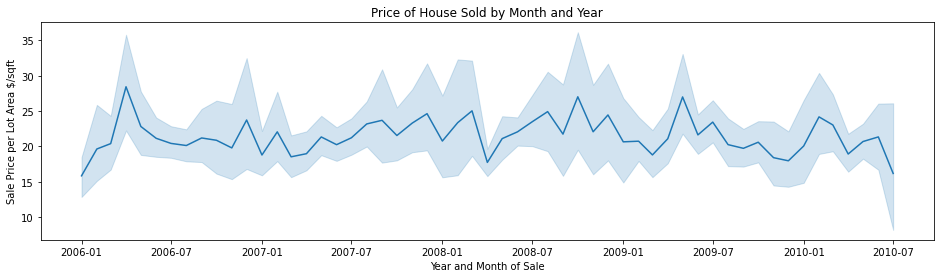

In [23]:
housing['Year_Mo'] = housing['Yr_Sold'].astype(str) + "-" + housing['Mo_Sold'].astype(str)
housing['Year_Mo'] = pd.to_datetime(housing['Year_Mo'], format='%Y-%m')

plt.figure(figsize=(16, 4))

sns.lineplot(data = housing,
                x=housing['Year_Mo'], 
                y=housing['SP_LA'],
               )

plt.title('Price of House Sold by Month and Year')
plt.ylabel('Sale Price per Lot Area $/sqft')
plt.xlabel('Year and Month of Sale');

## 2.3. Heatmap of Numeric Categories


Below, we create a heatmap of all numeric categories to view the correlation of numeric variables to Sale Price. For ease of visualization, absolute values are used. This is because directionality aside (positive or negative correlation), we would first like to view the strength of correlation with regards to the desired prediction (Sale Price). For the reasons outlined in Part 2.2., we will not include year or month sold.

**Caution:** Heatmap size is pretty large.

In [24]:
non_numeric_index = []
non_numeric_columns = []

for i, k in enumerate(housing.dtypes):
    if (k == 'object'):
        non_numeric_index.append(i)
        
for i in non_numeric_index:
    non_numeric_columns.append(f'\'{housing.columns[i]}\'')

housing_numeric = housing.drop(columns=['MS_Zoning', 'Street', 'Lot_Shape', 'Land_Contour', 'Utilities',
                                        'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2',
                                        'Bldg_Type', 'House_Style', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
                                        'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual', 'Exter_Cond', 'Foundation',
                                        'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2',
                                        'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'Kitchen_Qual', 'Functional',
                                        'Fireplace_Qu', 'Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond',
                                        'Paved_Drive', 'Pool_QC', 'Fence', 'Alley_Grvl', 'Alley_Pave', 
                                        'Misc_Feature_Yes', 'Lot_Frontage_Imputed', 'Yr_Sold', 'Mo_Sold', 'SP_LA'], axis=1)

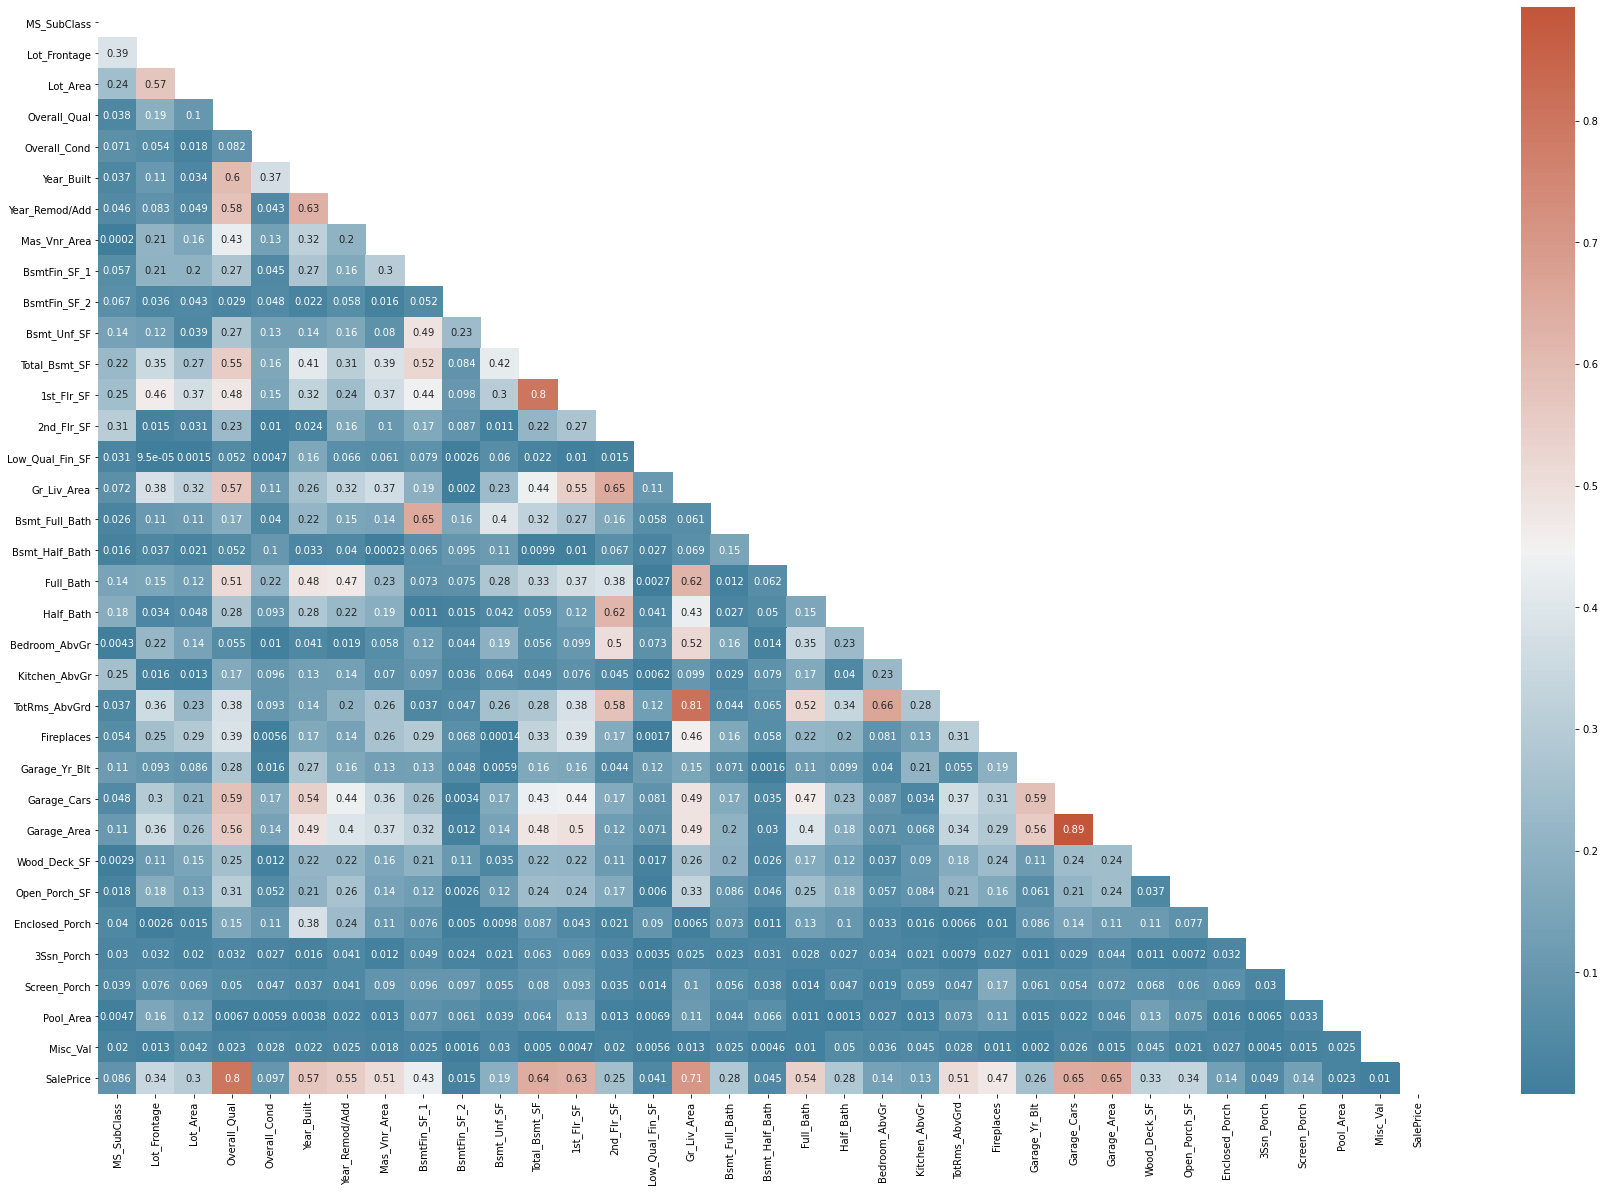

In [25]:
plt.figure(figsize=(30, 20))

corr = np.abs(housing_numeric.corr())

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, 
            cmap=cmap, 
            square=False, 
            annot=True, 
            fmt='.2g');

From the heatmap above, a few variables stand out as being more strongly correlated than others. The values increasingly change it's color from blue (weaker correlation) to red (stronger correlation). We will use the columns whose correlation is equal to or greater than 0.3. From this, we will be including the 17 following numeric columns for our model:

<code>'Lot_Frontage', 'Lot_Area', 'Overall_Qual', 'Year_Built', 'Year_Remod/Add', 'Mas_Vnr_Area',
'BsmtFin_SF_1', 'Total_Bsmt_SF', '1st_Flr_SF', 'Gr_Liv_Area', 'Full_Bath', 'TotRms_AbvGrd', 
'Fireplaces', 'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF', 'Open_Porch_SF'</code>

## 2.4. Selected Regplot Viewing

We show several regplots below to view the general trend of several X variables to sale price selected from the list in 2.3.1. Where outliers are present, we drop the values and provide justification for doing so.

### 2.4.1. Lot Area to Sale Price (2 Rows Dropped)

We regressed Lot Area to Sale Price and found a couple of outliers which we removed. This results in the elimination of 2 rows.

<blockquote><b>
        
    Old Shape: 2048 Rows, 82 Columns
    New Shape: 2046 Rows, 82 Columns

</b></blockquote>

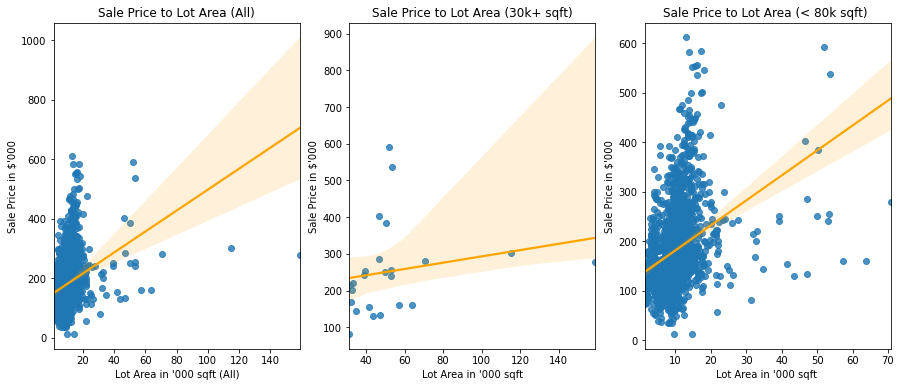

In [26]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.regplot(data=housing, 
            x=housing['Lot_Area']/1000,
            y=housing['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('Lot Area in \'000 sqft (All)')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to Lot Area (All)')

plt.subplot(1, 3, 2)
sns.regplot(data=housing,
            x=housing.loc[housing['Lot_Area'] > 30_000]['Lot_Area']/1000,
            y=housing.loc[housing['Lot_Area'] > 30_000]['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('Lot Area in \'000 sqft')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to Lot Area (30k+ sqft)')

plt.subplot(1, 3, 3)
sns.regplot(data=housing,
            x=housing.loc[housing['Lot_Area'] < 80_000]['Lot_Area']/1000,
            y=housing.loc[housing['Lot_Area'] < 80_000]['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('Lot Area in \'000 sqft ')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to Lot Area (< 80k sqft) ');

housing.drop(housing.loc[housing['Lot_Area'] > 80_000].index, inplace=True)

By regressing between lot area and sale price, we see a large area within its 95% confidence interval in the overall data (Left).

This is mainly caused by two outlier datapoints where the lot areas are larger than 100k sqft. Moreover, the 95% CI range is much larger for areas over 30k sqft (Center) than the overall data.

Two datapoints stand out in conducting this plot. There are two outliers with lot areas  larger than 100k sqft. Including these outliers will cause inaccuracies to our model and as such, we remove these two datapoints.

By removing these two outliers, we can see from the third graph (Right) that the 95% range has substantially been reduced and this provides a better confidence interval to use in our model.

### 2.4.2. Lot Frontage to Sale Price (2 Rows Dropped)

Similarly, we regressed Lot Frontage to Sale Price and found a couple of outliers which we removed. This results in the elimination of 2 rows.

<blockquote><b>
        
    Old Shape: 2046 Rows, 82 Columns
    New Shape: 2044 Rows, 82 Columns

</b></blockquote>

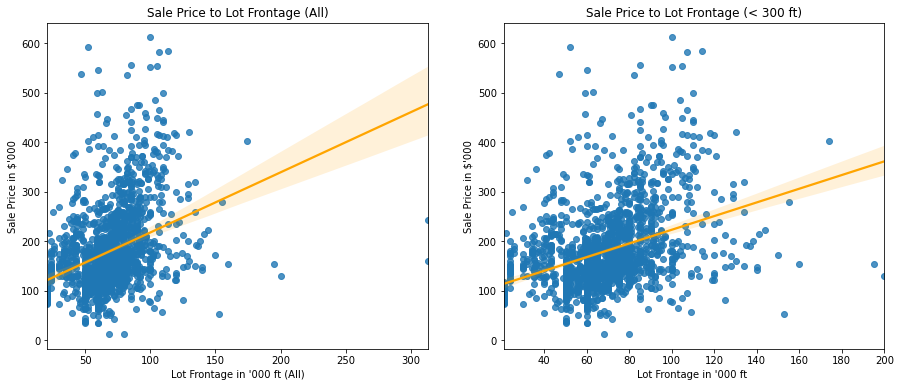

In [27]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=housing, 
            x=housing['Lot_Frontage'],
            y=housing['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('Lot Frontage in \'000 ft (All)')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to Lot Frontage (All)')

housing.drop(housing.loc[housing['Lot_Frontage'] > 300].index, inplace=True)

plt.subplot(1, 2, 2)
sns.regplot(data=housing,
            x=housing['Lot_Frontage'],
            y=housing['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('Lot Frontage in \'000 ft ')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to Lot Frontage (< 300 ft)');



Similar to Lot Area, we regress Lot Frontage to Sale Price and compare the difference between the range of the 95% confidence interval of all datapoints with and without the outliers.

The overall graph (Left) shows a much larger range within the 95% CI due to the inclusion of two outliers whose Lot Frontage is over 300ft. As these outliers were removed, we see a smaller range within the 95% CI as shown on the graph on the right.

### 2.4.3. Masonry Veneer Area to Sale Price (1 Row Dropped)

Similarly, we regressed Masonry Veneer Area to Sale Price and found an outlier which we removed. This results in the elimination of 1 row.

<blockquote><b>
        
    Old Shape: 2044 Rows, 82 Columns
    New Shape: 2043 Rows, 82 Columns

</b></blockquote>

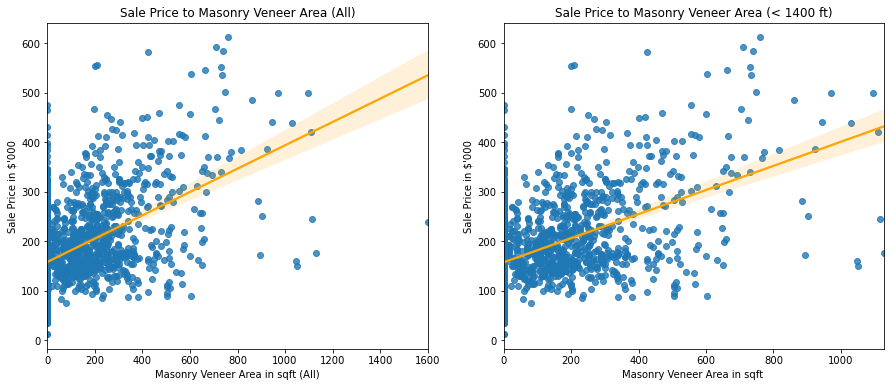

In [28]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=housing, 
            x=housing['Mas_Vnr_Area'],
            y=housing['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('Masonry Veneer Area in sqft (All)')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to Masonry Veneer Area (All)')

housing.drop(housing.loc[housing['Mas_Vnr_Area'] > 1400].index, inplace=True)

plt.subplot(1, 2, 2)
sns.regplot(data=housing,
            x=housing['Mas_Vnr_Area'],
            y=housing['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('Masonry Veneer Area in sqft ')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to Masonry Veneer Area (< 1400 ft)');

We regress Masonry Veneer Area with and without an outlier where Masonry Veneer Area is over 1,400sqft. This improvement can be seen between the difference in range of the 95% confidence interval before (Left) and after (Right) the outlier was removed.

### 2.4.4. First Floor Area Area to Sale Price (1 Row Dropped)

Similarly, we regressed First Floor Area to Sale Price and found an outlier which we removed. This results in the elimination of 1 row.

<blockquote><b>
        
    Old Shape: 2043 Rows, 82 Columns
    New Shape: 2042 Rows, 82 Columns

</b></blockquote>

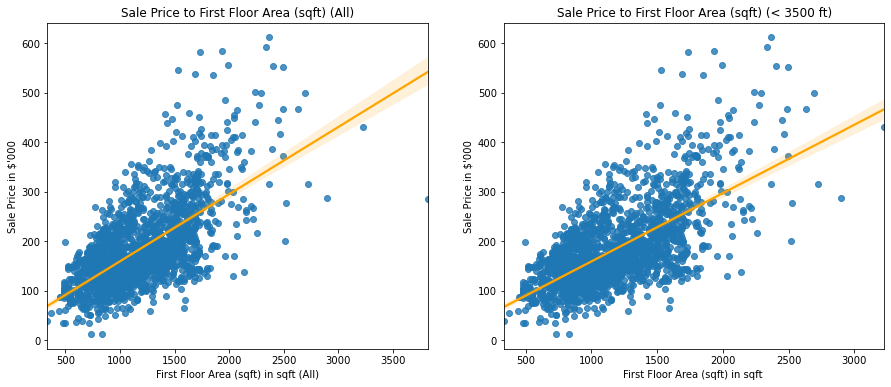

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=housing, 
            x=housing['1st_Flr_SF'],
            y=housing['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('First Floor Area (sqft) in sqft (All)')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to First Floor Area (sqft) (All)')

housing.drop(housing.loc[housing['1st_Flr_SF'] > 3500].index, inplace=True)

plt.subplot(1, 2, 2)
sns.regplot(data=housing,
            x=housing['1st_Flr_SF'],
            y=housing['SalePrice']/1000,
            line_kws={'color': 'orange'})
plt.xlabel('First Floor Area (sqft) in sqft ')
plt.ylabel('Sale Price in $\'000')
plt.title('Sale Price to First Floor Area (sqft) (< 3500 ft)');

In the spirit of eliminating outliers, we removed a datapoint where the First Floor Area is greater than 3500sqft. Whiile this does not significantly affect our model, we believe that it is prudent to remove datapoints which may create unnecessary complications. The two graphs above show regression plots before (Left) and after (Right) the outlier was removed.

In [30]:
len(housing['Neighborhood'].unique())

28

## 2.5. Feature Engineering

In this section, we create several features in addition to what we have, which may be helpful in improving our model. The following are the list of features engineered:

    1. SP_LA: Sale Price per Lot Area ($/sqft) (Part 2.1.1.)
    2. House_Sold_Age: Age of House at Sale

### 2.5.1. House Age

We create a column called 'House_Sold_Age' to denote the age of the house when it was sold. This is obtained by subtracting the year where the property is built from the year it is sold. We observe that in general, as the property age gets higher, they are valued at a discount in dollars per square foot as compared to newer houses.

<blockquote><b>
        
    Old Shape: 2042 Rows, 82 Columns
    New Shape: 2042 Rows, 83 Columns

</b></blockquote>

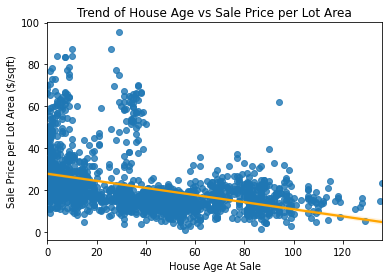

In [31]:
housing['House_Sold_Age'] = housing['Yr_Sold'] - housing['Year_Built']

sns.regplot(data=housing,
            x='House_Sold_Age',
            y='SP_LA',
            line_kws={'color': 'orange'}
           )
plt.title('Trend of House Age vs Sale Price per Lot Area')
plt.ylabel('Sale Price per Lot Area ($/sqft)')
plt.xlabel('House Age At Sale');

# Part 3: Predictive Modeling <a class="anchor" id="Predictive_Modeling"></a>

In this section, we will conduct several predictive modeling using linear regression and applicable penalties, and compare the results to our baseline model.

## 3.1. Baseline Model

In our baseline model, we will use one variable (Lot Area) which is most commonly used to make a first estimate of Sale Price.

<blockquote><b>
        
    Number of Variable(s) Used: 1

</b></blockquote>

Our baseline linear regression model provides us the following results:

|Train/Test|Metric|Result|
|----------|------|------|
|<center>Train</center>|<center>$R^2$</center>|0.126|
|<center>Test</center>|<center>$R^2$</center>|0.116|
|<center>Train</center>|<center>Cross Val Score $R^2$</center>|0.104|
|<center>Train</center>|<center>RMSE</center>|\$74,194|
|<center>Test</center>|<center>RMSE</center>|\$74,047|

**Observations:**

We observe a large RMSE in both the train and test sets of this baseline model, and a low $R^2$, which suggests that the baseline model is not very predictive of our target and should be improved upon.

In [32]:
housing.reset_index(drop=True, inplace=True)

X = housing[['Lot_Area']]
y = housing['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=404,
                                                   )

lr = LinearRegression()

lr.fit(X_train, y_train)

Baseline_Model_Train_Score = lr.score(X_train, y_train)
Baseline_Model_Test_Score = lr.score(X_test, y_test)
Baseline_Model_CVS = cross_val_score(lr,
                                                 X_train,
                                                 y_train,
                                                 cv=5
                                                ).mean()

print(f'Baseline Model R^2 Train Score:  {round(Baseline_Model_Train_Score, 3)}')
print(f'Baseline Model R^2 Test Score:   {round(Baseline_Model_Test_Score, 3)}')
print(f'Baseline Model Cross Val Score:  {round(Baseline_Model_CVS, 3)}')
print(f'Train RMSE:                     ${round(metrics.mean_squared_error(y_train, lr.predict(X_train))**0.5, 0)}')
print(f'Test RSME:                      ${round(metrics.mean_squared_error(y_test, lr.predict(X_test))**0.5, 0)}')

Baseline Model R^2 Train Score:  0.126
Baseline Model R^2 Test Score:   0.116
Baseline Model Cross Val Score:  0.104
Train RMSE:                     $74194.0
Test RSME:                      $74047.0


## 3.2. Numerical Categories Model

In this section, we conduct an elastic net models to determine which penalization is more appropriate as well as which variables should be used.

### 3.2.1. Elastic Net

For our first elastic net, we will be using our numerical categories, and a few dummy variables. 

<blockquote><b>
        
    Number of Variable(s) Used: 21

</b></blockquote>

Our using numeric categories model give us:

|Train/Test|Metric|Result|
|----------|------|------|
|<center>n/a</center>|<center>alpha</center>|87.625|
|<center>n/a</center>|<center>L1 Ratio</center>|1.0|
|<center>Train</center>|<center>$R^2$</center>|0.867|
|<center>Test</center>|<center>$R^2$</center>|0.868|
|<center>Train</center>|<center>RMSE</center>|\$28,975|
|<center>Test</center>|<center>RMSE</center>|\$28,585|

**Observations:**

We observe several things from running this model. 

1. This model provides a much greater $R^2$ in both the train and test sets than our baseline model.

2. Furthermore, using these 21 variables provide us with a much lower RMSE for both our train and test sets, and provides a more favorable outcome as it means that our error value is decreasing.

3. Comparing the training and testing RMSE, we see a lower value for the testing RMSE while a larger $R^2$, which suggests that we have to worry about overfitting.

In [33]:
X = housing[['Lot_Area', 'Overall_Qual', 'Year_Built', 'Year_Remod/Add', 
             'Mas_Vnr_Area', 'BsmtFin_SF_1', 'Total_Bsmt_SF', '1st_Flr_SF', 
             'Gr_Liv_Area', 'Full_Bath', 'TotRms_AbvGrd', 'Fireplaces', 
             'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF', 'Open_Porch_SF', 'SP_LA', 
             'Lot_Frontage_Imputed', 'Alley_Pave', 'Alley_Grvl', 'Misc_Feature_Yes']]
y = housing['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=404
                                                   )

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

enet_l1_ratio = np.logspace(-3, 0, 100)
enet_alphas = np.linspace(1, 100, 25)
enet = ElasticNetCV(alphas=enet_alphas,
                    l1_ratio=enet_l1_ratio,
                    cv=5
                   )

enet_model = enet.fit(X_train_sc, y_train)

print(f'Elastic Net Alpha:            {enet.alpha_}')
print(f'Elastic Net l1 Ratio:         {round(enet_model.l1_ratio_, 1)}')
print(f'Elastic Net R^2 Train Score:  {round(enet.score(X_train_sc, y_train), 3)}')
print(f'Elastic Net R^2 Test Score:   {round(enet.score(X_test_sc, y_test), 3)}')
print(f'Train RMSE:                  ${round(metrics.mean_squared_error(y_train, enet.predict(X_train_sc))**0.5, 0)}')
print(f'Test RMSE:                   ${round(metrics.mean_squared_error(y_test, enet.predict(X_test_sc))**0.5, 0)}')
pd.DataFrame(enet.coef_, index=X.columns).T

Elastic Net Alpha:            100.0
Elastic Net l1 Ratio:         1.0
Elastic Net R^2 Train Score:  0.867
Elastic Net R^2 Test Score:   0.868
Train RMSE:                  $28975.0
Test RMSE:                   $28585.0


,Lot_Area,Overall_Qual,Year_Built,Year_Remod/Add,Mas_Vnr_Area,BsmtFin_SF_1,Total_Bsmt_SF,1st_Flr_SF,Gr_Liv_Area,Full_Bath,...,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,SP_LA,Lot_Frontage_Imputed,Alley_Pave,Alley_Grvl,Misc_Feature_Yes
0,9444.571569,24512.444956,5084.060764,7920.6503,5358.468967,9960.34196,7481.440731,3444.775313,23349.971046,-2346.166931,...,1803.231308,-418.593126,6437.95674,1201.056756,1585.619722,6637.062234,2337.956538,-2212.614154,0.0,-467.789421


### 3.2.2. Lasso Model

Fromm our previous elastic net in Section 3.2.1., the l1 ratio provided is 1, which signifies that a lasso model is more appropriate for this regression than a ridge model. In this section, we create lasso models for our predictive model.

<blockquote><b>
        
    Number of Variable(s) Used: 21

</b></blockquote>

For our first lasso, we will be using our numerical categories, and a few dummy variables.

|Train/Test|Metric|Result|
|----------|------|------|
|<center>n/a</center>|<center>alpha</center>|1.0|
|<center>Train</center>|<center>$R^2$</center>|0.867|
|<center>Test</center>|<center>$R^2$</center>|0.868|
|<center>Train</center>|<center>RMSE</center>|\$28,967|
|<center>Test</center>|<center>RMSE</center>|\$28,572|


**Observations:**

We observe this model and compare the results from the previous model in 3.2.1. and this model:

1. $R^2$ for both train and test set remains similar (0.867 and 0.868 respectively).
2. RMSE for both training and testing set has slightly improved (28,975 vs 28,967 and 28,585 vs 28,572).
3. This similarity is due to the Elastic-Net Model essentially using a Lasso Model since the l1 ratio is 1.
4. The higher training results when compared to the testing sets suggest that there is overfitting. Our training set has been set to overfit the testing set even in the presence of the L1 penalty. As such, we need to recalibrate our variable selection.
5. Numeric categories may not suffice in creating this predictive model. As such, we should consider decreasing the number of numeric categories used and select several non-numerical categories.

In [34]:
X = housing[['Lot_Area', 'Overall_Qual', 'Year_Built', 'Year_Remod/Add', 
             'Mas_Vnr_Area', 'BsmtFin_SF_1', 'Total_Bsmt_SF', '1st_Flr_SF', 
             'Gr_Liv_Area', 'Full_Bath', 'TotRms_AbvGrd', 'Fireplaces', 
             'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF', 'Open_Porch_SF', 'SP_LA', 
             'Lot_Frontage_Imputed', 'Alley_Pave', 'Alley_Grvl', 'Misc_Feature_Yes']]
y = housing['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=404
                                                   )

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(
    alphas=l_alphas,
    cv=5,
    max_iter=50_000
)

lasso_cv.fit(X_train_sc, y_train)

print(f'Lasso Alpha:                {lasso_cv.alpha_}')
print(f'Lasso R^2 Train Score:      {round(lasso_cv.score(X_train_sc, y_train), 3)}')
print(f'Lasso R^2 Test Score:       {round(lasso_cv.score(X_test_sc, y_test), 3)}')
print(f'Train RMSE:                 {round(metrics.mean_squared_error(y_train, lasso_cv.predict(X_train_sc))**0.5, 0)}')
print(f'Test RMSE:                  {round(metrics.mean_squared_error(y_test, lasso_cv.predict(X_test_sc))**0.5, 0)}')
pd.DataFrame(lasso_cv.coef_, index=X.columns).T

Lasso Alpha:                1.0
Lasso R^2 Train Score:      0.867
Lasso R^2 Test Score:       0.868
Train RMSE:                 28967.0
Test RMSE:                  28572.0


,Lot_Area,Overall_Qual,Year_Built,Year_Remod/Add,Mas_Vnr_Area,BsmtFin_SF_1,Total_Bsmt_SF,1st_Flr_SF,Gr_Liv_Area,Full_Bath,...,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,SP_LA,Lot_Frontage_Imputed,Alley_Pave,Alley_Grvl,Misc_Feature_Yes
0,9538.560019,24412.160698,5338.448485,8032.425839,5366.48798,9913.183198,7470.719203,3420.915834,23950.407338,-2579.091544,...,1839.121591,-1504.177968,7263.147426,1244.249737,1599.569505,6860.35337,2502.18684,-2337.422175,175.961628,-575.754267


## 3.3. Combined Numeric & Non-Numeric Categories

In this section, we explore the usage of using several non-numeric categories and applying it to our model.

### 3.3.1. Combined Variable Model

In this model, we attempt to incorporate both numerical and qualitative variables and compare the results with the baseline and the previous numeric categories model.

<blockquote><b>
        
    Number of Variable(s) Used: 11
    Target RMSE: $32,044

</b></blockquote>

|Train/Test|Metric|Result|
|----------|------|------|
|<center>n/a</center>|<center>alpha</center>|1.0|
|<center>Train</center>|<center>$R^2$</center>|0.883|
|<center>Test</center>|<center>$R^2$</center>|0.872|
|<center>Train</center>|<center>RMSE</center>|\$27,175|
|<center>Test</center>|<center>RMSE</center>|\$28,156|

**Observations:**

1. We see an improvement in our $R^2$ and RMSE for both training and testing data, suggesting that the increased number of variables used has provided a boon towards our predictive model.
2. The improvement in $R^2$ can be attributed to the usage of qualitative data such as Neighborhood, which may have a greater effect than the numeric variables it had replaced. Neighborhood seems like a good qualitative variable due to other accompanying factors which are not in our dataset. For instance, the difference in neighborhoods affect HOA fees and school district. As such, some neighborhoods are valued at a premium than others due to the level of HOA fees and quality of schools.
3. When compared to Kaggle's target, our RMSE performed worse, which is to be expected. However, we may want to tweak the model a little more to ensure that there is an appropriate amount of bias and variance.

In [35]:
model_selection = housing[['SalePrice', 'Neighborhood', 'Gr_Liv_Area', 'Overall_Qual',
                           'Total_Bsmt_SF', 'House_Sold_Age', 'MS_SubClass', 'Garage_Area',
                           'Lot_Area', 'Exter_Qual', 'Exterior_1st', 'Heating']]

object_columns = ['MS_SubClass']
                      
for column_index, column_type in enumerate(model_selection.dtypes):
    if column_type == 'object':
        object_columns.append(model_selection.columns[column_index])

model_selection = pd.get_dummies(data=model_selection,
                                 columns=object_columns
                                )
model_selection.reset_index(drop=True, inplace=True)


                      
X = model_selection.drop(columns=['SalePrice', 'MS_SubClass_150', 'Neighborhood_GrnHill', 
                                  'Neighborhood_Landmrk', 'Heating_OthW', 'Heating_Wall',
                                  'Exterior_1st_CBlock', 'Exterior_1st_ImStucc', 'Exterior_1st_Stone'
                                 ])
y = model_selection['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=404
                                                   )

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(
    alphas=l_alphas,
    cv=5,
    max_iter=100_000,
)

lasso_cv.fit(X_train_sc, y_train)

print(f'Lasso Alpha:                {lasso_cv.alpha_}')
print(f'Lasso R^2 Train Score:      {round(lasso_cv.score(X_train_sc, y_train), 5)}')
print(f'Lasso R^2 Test Score:       {round(lasso_cv.score(X_test_sc, y_test), 5)}')
print(f'Train RMSE:                 {round(metrics.mean_squared_error(y_train, lasso_cv.predict(X_train_sc))**0.5, 0)}')
print(f'Test RMSE:                  {round(metrics.mean_squared_error(y_test, lasso_cv.predict(X_test_sc))**0.5, 0)}')

coefs = pd.DataFrame(lasso_cv.coef_, index=X.columns).T    
# coefs.drop(columns=[], inplace=True)



Lasso Alpha:                1.0
Lasso R^2 Train Score:      0.88275
Lasso R^2 Test Score:       0.8722
Train RMSE:                 27175.0
Test RMSE:                  28156.0


### 3.3.2. Minimal Variable Model

In this model, we attempt to minimize the number of variables we use and compare the results with the baseline and the previous numeric categories model.

<blockquote><b>
        
    Number of Variable(s) Used: 7
    Target RMSE: $31,962

</b></blockquote>

|Train/Test|Metric|Result|
|----------|------|------|
|<center>n/a</center>|<center>alpha</center>|0.001|
|<center>Train</center>|<center>$R^2$</center>|0.868|
|<center>Test</center>|<center>$R^2$</center>|0.856|
|<center>Train</center>|<center>RMSE</center>|\$28,815|
|<center>Test</center>|<center>RMSE</center>|\$29,894|

**Observations:**

Comparing with our numeric lasso model (3.2.2.):

1. We observe a slight improvement in training $R^2$ as compared to the previous lasso model (0.868 vs 0.867), and a slight reduction in testing $R^2$ (0.856 vs 0.868).
2. We observe a slight improvement in training RMSE (28,815 vs 28,967) and a slight worsening of testing RMSE (29,894 vs 28,572).

Comparing with our combined lasso model (3.3.1.):

1. This model had used a subset of variables used in the the previous lasso model. By using less variables, this model had worse $R^2$ and RMSE scores.
2. However, applied to a blind target set, target RMSE had instead improved. This incompatible results can be attributed to the variables not used in the previous model. It appears that the additional variables used in 3.3.1. had contributed to extra noise, and had overfitted to our test set. As a result, our target set RMSE reacted poorly to the extra variables. 

A significant observation is that our training models appear to have improved as compared to our previous lasso model by using just 8 variables as opposed to 21 and 11 variables. We recognize this as an increased bias due to less variables used.
An increase in unfavorability in testing score and RMSE as compared to its training counterpart is expected. Coupled with the significant reduction in number of variables, this model should not have issues with overfitting. 

In [36]:
model_selection = housing[['SalePrice', 'Neighborhood', 'Gr_Liv_Area', 'Overall_Qual',
                           'Total_Bsmt_SF', 'House_Sold_Age', 'MS_SubClass', 'Garage_Area',]]

object_columns = ['MS_SubClass']
                      
for column_index, column_type in enumerate(model_selection.dtypes):
    if column_type == 'object':
        object_columns.append(model_selection.columns[column_index])

model_selection = pd.get_dummies(data=model_selection,
                                 columns=object_columns
                                )
model_selection.reset_index(drop=True, inplace=True)


                      
X = model_selection.drop(columns=['SalePrice', 'MS_SubClass_150', 
                                  'Neighborhood_GrnHill', 'Neighborhood_Landmrk'])
y = model_selection['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=404)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

l_alphas = np.logspace(-3, 0, 100)

lasso_cv = LassoCV(
    alphas=l_alphas,
    cv=5,
    max_iter=100_000)

lasso_cv.fit(X_train_sc, y_train)

print(f'Lasso Alpha:                {lasso_cv.alpha_}')
print(f'Lasso R^2 Train Score:      {round(lasso_cv.score(X_train_sc, y_train), 5)}')
print(f'Lasso R^2 Test Score:       {round(lasso_cv.score(X_test_sc, y_test), 5)}')
print(f'Train RMSE:                 {round(metrics.mean_squared_error(y_train, lasso_cv.predict(X_train_sc))**0.5, 0)}')
print(f'Test RMSE:                  {round(metrics.mean_squared_error(y_test, lasso_cv.predict(X_test_sc))**0.5, 0)}')

coefs = pd.DataFrame(lasso_cv.coef_, index=X.columns).T    

Lasso Alpha:                0.001
Lasso R^2 Train Score:      0.86817
Lasso R^2 Test Score:       0.85595
Train RMSE:                 28815.0
Test RMSE:                  29894.0


# Part 4: Target Model <a class="anchor" id="Target_Model"></a>

In this section, we read and process the target data to test against our trained model.

## Part 4.1. Reading and Renaming Target Columns

We conduct the same steps as we have conducted in Part 1:

1. Reading data
2. Renaming data by replacing spaces to underscores.

In [37]:
housing_target = pd.read_csv('datasets/test.csv')
housing_target.columns = housing_target.columns.str.replace(' ', '_')
housing_target_old = housing_target

## Part 4.2. Deductive Imputations

Similar to Part 1.4., we convert null values to 0 wherever applicable.

In [38]:
nan_to_zero_list = ['Mas_Vnr_Area', 'Mas_Vnr_Type', 'BsmtFin_SF_1', 'Total_Bsmt_SF',
                    'Bsmt_Full_Bath', 'Bsmt_Unf_SF', 'Bsmt_Half_Bath', 'Garage_Yr_Blt',
                    'Garage_Type', 'BsmtFin_SF_2', 'Garage_Cars', 'Garage_Area']

for column in nan_to_zero_list:
    housing_target[column] = housing_target[column].fillna(0)

## Part 4.3. Convert Ordinals from String to Numeric

Similar to Part 1.5., we convert string ordinal values into numeric ordinal values to enable processing by our model.

### Part 4.3.1. 3-Value Ordinals

Similar to Part 1.5.1. we convert 3-value ordinals from string to numeric form.

In [39]:
housing_target['Utilities'] = housing_target['Utilities'].map({'AllPub': 3, 
                                                               'NoSeWa': 2, 
                                                               'NoSewr': 1})

housing_target['Land_Slope'] = housing_target['Land_Slope'].map({'Gtl': 3,
                                                                 'Mod': 2,
                                                                 'Sev': 1})

housing_target['Paved_Drive'] = housing_target['Paved_Drive'].map({'Y': 3,
                                                                   'P': 2,
                                                                   'N': 1})

housing_target['Garage_Finish'] = housing_target['Garage_Finish'].fillna('NA').map({'Fin': 3,
                                                                                    'RFn': 2,
                                                                                    'Unf': 1,
                                                                                    'NA': 0})

### Part 4.3.2. 4-Value Ordinals

Similar to Part 1.5.2. we convert 4-value ordinals from string to numeric form.

In [40]:
housing_target['Lot_Shape'] = housing_target['Lot_Shape'].map({'Reg': 4,
                                                               'IR1': 3,
                                                               'IR2': 2,
                                                               'IR3': 1})

housing_target['Fence'] = housing_target['Fence'].fillna('NA').map({'GdPrv': 4,
                                                                    'MnPrv': 3,
                                                                    'GdWo': 2,
                                                                    'MnWw': 1,
                                                                    'NA': 0})

housing_target['Bsmt_Exposure'] = housing_target['Bsmt_Exposure'].fillna('NA').map({'Gd': 4,
                                                                                    'Av': 3,
                                                                                    'Mn': 2,
                                                                                    'No': 1,
                                                                                    'NA': 0})

ordinal_4_list_1 = ['Exter_Qual', 'Pool_QC']

ordinal_4_scale_1 = {'Ex': 4,
                     'Gd': 3,
                     'TA': 2,
                     'Fa': 1,
                     'NA': 0,
                    }

for column in ordinal_4_list_1:
    housing_target[column] = housing_target[column].fillna('NA').map(ordinal_4_scale_1)

### Part 4.3.3. 5-Value Ordinals

Similar to Part 1.5.3. we convert 5-value ordinals from string to numeric form.

In [41]:
housing_target['Electrical'] = housing_target['Electrical'].fillna('NA').map({'SBrkr': 5,
                                                                              'FuseA': 4,
                                                                              'FuseF': 3,
                                                                              'FuseP': 2,
                                                                              'Mix': 1,
                                                                              'NA': 0})
    
ordinal_5_list_1 = ['Exter_Cond', 'Heating_QC']
ordinal_5_scale_1 = {'Ex': 5,
                     'Gd': 4,
                     'Fa': 3,
                     'TA': 2,
                     'Po': 1,}
for column in ordinal_5_list_1:
    housing_target[column] = housing_target[column].map(ordinal_5_scale_1)
    
ordinal_5_list_2 = ['Fireplace_Qu', 'Bsmt_Qual', 'Bsmt_Cond', 'Garage_Qual', 'Garage_Cond', 'Kitchen_Qual']
ordinal_5_scale_2 = {'Ex': 5,
                     'Gd': 4,
                     'Fa': 3,
                     'TA': 2,
                     'Po': 1,
                     'NA': 0}
for column in ordinal_5_list_2:
    housing_target[column] = housing_target[column].fillna('NA').map(ordinal_5_scale_2)

### Part 4.3.4. 6-Value Ordinals

Similar to Part 1.5.4. we convert 6-value ordinals from string to numeric form.

In [42]:
ordinal_6_list = ['BsmtFin_Type_1', 'BsmtFin_Type_2']
ordinal_6_scale = {'GLQ': 6,
                   'ALQ': 5,
                   'BLQ': 4,
                   'Rec': 3,
                   'LwQ': 2,
                   'Unf': 1,
                   'NA': 0}

for column in ordinal_6_list:
    housing_target[column] = housing_target[column].fillna('NA').map(ordinal_6_scale)

### Part 4.3.5. 8-Value Ordinals

Similar to Part 1.5.5. we convert 8-value ordinals from string to numeric form.

In [43]:
housing['Functional'] = housing['Functional'].map({'Typ': 8,
                                                   'Min1': 7,
                                                   'Min2': 6,
                                                   'Mod': 5,
                                                   'Maj1': 4,
                                                   'Maj2': 3,
                                                   'Sev': 2,
                                                   'Sal': 1
                                        })

### Part 4.3.6. Dummy Alley

Similar to Part 1.7.1., we convert Alley into two dummies: Gravel (Alley_Grvl) or Paved (Alley_Pave).

In [44]:
housing_target = pd.get_dummies(housing_target,
                    columns=['Alley'])

### Part 4.3.7. Dummify Misc Features

Accordingly, we dummify Miscellaneous Features from its categorical features to binary, where '1' and '0' refers to the presence or absence of miscellaneous features in the property. This is similar to Part 1.7.2.

In [45]:
misc_feature_list = ['Shed', 'Gar2', 'Othr', 'TenC']
housing_target['Misc_Feature_Yes'] = [0 if feature not in misc_feature_list else 1 for feature in housing_target['Misc_Feature']]
housing_target.drop(columns=['Misc_Feature'], inplace=True)

### Part 4.3.8. Feature Engineering

Lastly, we engineer a feature used in our final model: House_Sold_Age, which reflects the age of the property at the year sold. This is similar to Part 2.5.1.

In [46]:
housing_target['House_Sold_Age'] = housing_target['Yr_Sold'] - housing_target['Year_Built']

## Part 4.4. Model Application

We select variables based on our best lasso model (Part 3.3.1.) and run our model to obtain our Kaggle score.

<blockquote><b>
    
    Kaggle RMSE: 31,962
    
</b></blockquote>

While we had used a minimalist approach with just 8 variables, we had attained a significantly better model as compared to our baseline (1 variable) or our numeric category lasso (21 variables). By combining our conservatism in number of variables used and using non-numeric variables in our model, we found an area to which our model remains within the goldilocks zone.

In [47]:
X_target_model_selection = housing_target[['Neighborhood', 'Gr_Liv_Area', 'Overall_Qual', 'Total_Bsmt_SF', 
                                           'House_Sold_Age', 'MS_SubClass', 'Garage_Area']]

X_target_object_columns = ['MS_SubClass']

for column_index, column_type in enumerate(model_selection.dtypes):
    if column_type == 'object':
        object_columns.append(X_target_model_selection.columns[column_index])

X_target_model_selection = pd.get_dummies(data=X_target_model_selection,
                                 columns=object_columns
                                )
X_target_model_selection.reset_index(drop=True, inplace=True)

X_target = X_target_model_selection

X_target_sc = ss.fit_transform(X_target)
y_target = lasso_cv.predict(X_target_sc)

# Uncomment the for-loop below to obtain Id and predicted SalePrice
# for index, value in enumerate(pd.Series(y_target)):
#     print(housing_target['Id'][index], value)

## Part 5: Conclusion and Recommendations <a class="anchor" id="Conclusion"></a>

We conclude by noting several observations:

Predicting sale price of a property using just lot are is insufficient. Similarly, using only numerical variables is insufficient. A mix of quantitative and qualitative categories provide for a better predictive model than simply using one or the other. To this point, increasing the number of variables used does not necessarily improve the results as it may contribute instead to overfitting. In the event where a predictive model is overfit, inaccuracies will arise in blind data sets and contribute to the unreliability of the model. As such, the best practice is to find and include only the most important few variables that buyers look for when purchasing a property. This way, we can remain in the goldilocks zone where error rates decrease as we add more variables into our predictive models.

We provide a model based on only 7 out of 81 variables provided. While this may seem like a small number of variables (and it is), we remain pretty confident in being in the goldilocks zone, minimizing our number of variables at the expense of a larger RMSE. 

However, we believe that this model can be improved by the inclusion of high-impact variables which are not in our dataseet. We recommend gathering more data on neighborhood-based features such as school district and its relevant rating due to its inherent value which is not correlated with any single property but affects the value of an area. Other data that we recommend gathering are: proximity to highways and day to day necessities (markets, entertainment areas) and public safety information such as neighborhood crime rates.